In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 1 1 0 0 1 0 0 2 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 2]


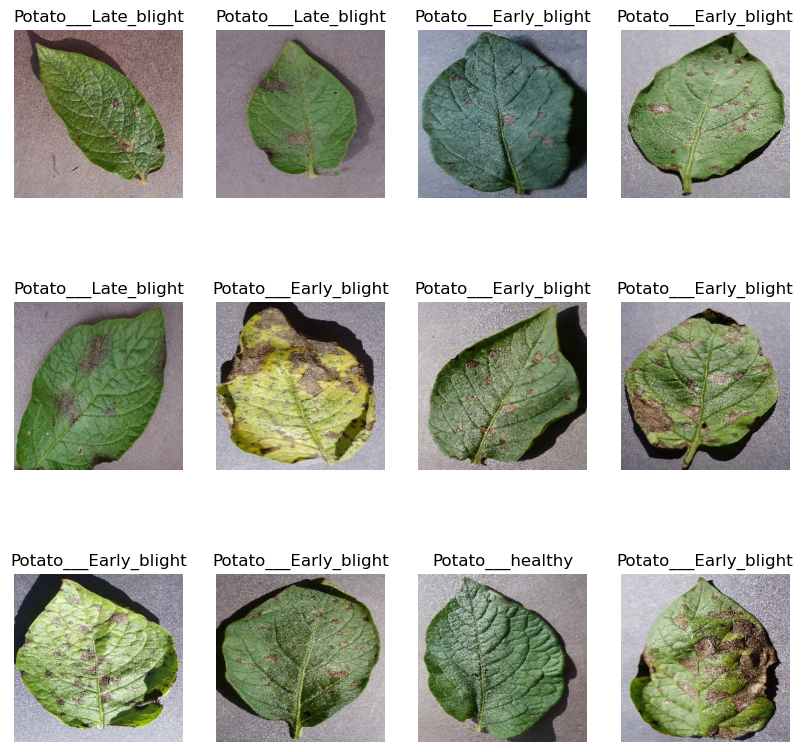

In [8]:
#data visualization
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

68

In [10]:
#80->training, 10->vadilation, 10->test
#train_test_split in sklearn, dataset.take(10) takes first 10sample

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds=dataset.take(54)
len(train_ds)

54

In [12]:
test_ds=dataset.skip(54)  #skipping first 54,  both vadilation and test
len(test_ds)

14

In [13]:
val_ds=0.1
len(dataset)*val_ds

6.800000000000001

In [14]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds=test_ds.take(6)
len(test_ds)

6

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
#preprocessing - resizing and normalization, data augmentation(for robustness)
import tensorflow as tf
from tensorflow.keras import layers
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [20]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.1),
])

In [21]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model = tf.keras.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )

from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [24]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20


54/54 [==============================] - 74s 1s/step - loss: 0.9002 - accuracy: 0.4919 - val_loss: 0.8321 - val_accuracy: 0.5208
Epoch 2/20
54/54 [==============================] - 60s 1s/step - loss: 0.7433 - accuracy: 0.6291 - val_loss: 0.5629 - val_accuracy: 0.7656
Epoch 3/20
54/54 [==============================] - 49s 902ms/step - loss: 0.5086 - accuracy: 0.7656 - val_loss: 0.3594 - val_accuracy: 0.8802
Epoch 4/20
54/54 [==============================] - 51s 938ms/step - loss: 0.3765 - accuracy: 0.8495 - val_loss: 0.2996 - val_accuracy: 0.9062
Epoch 5/20
54/54 [==============================] - 48s 884ms/step - loss: 0.3159 - accuracy: 0.8779 - val_loss: 0.2946 - val_accuracy: 0.8646
Epoch 6/20
54/54 [==============================] - 46s 848ms/step - loss: 0.2408 - accuracy: 0.9097 - val_loss: 0.1506 - val_accuracy: 0.9375
Epoch 7/20
54/54 [==============================] - 45s 839ms/step - loss: 0.1659 - accuracy: 0.9352 - val_loss: 0.1191 - val_accuracy: 0.9531
Epo

In [25]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 7s 303ms/step - loss: 0.1136 - accuracy: 0.9727


In [26]:
scores

[0.1135627031326294, 0.97265625]

In [27]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history.history['accuracy']

[0.49189814925193787,
 0.6290509104728699,
 0.765625,
 0.8495370149612427,
 0.8778935074806213,
 0.9097222089767456,
 0.9351851940155029,
 0.8726851940155029,
 0.8663194179534912,
 0.9131944179534912,
 0.9120370149612427,
 0.9461805820465088,
 0.9745370149612427,
 0.9641203880310059,
 0.9652777910232544,
 0.9797453880310059,
 0.9820601940155029,
 0.9733796119689941,
 0.9444444179534912,
 0.9797453880310059]

In [30]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

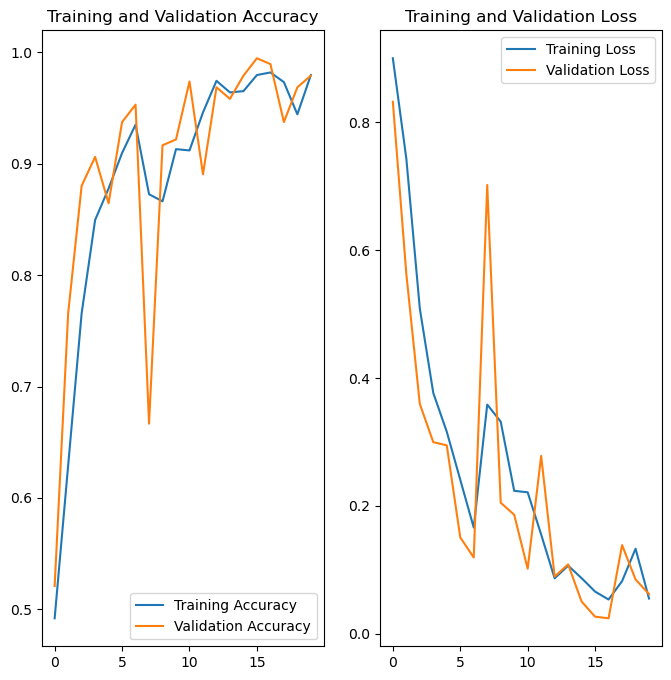

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 259ms/step
predicted label: Potato___Late_blight


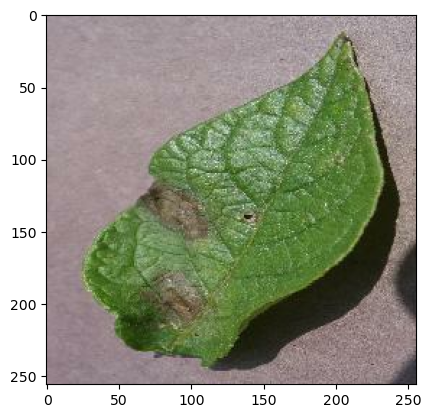

In [50]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


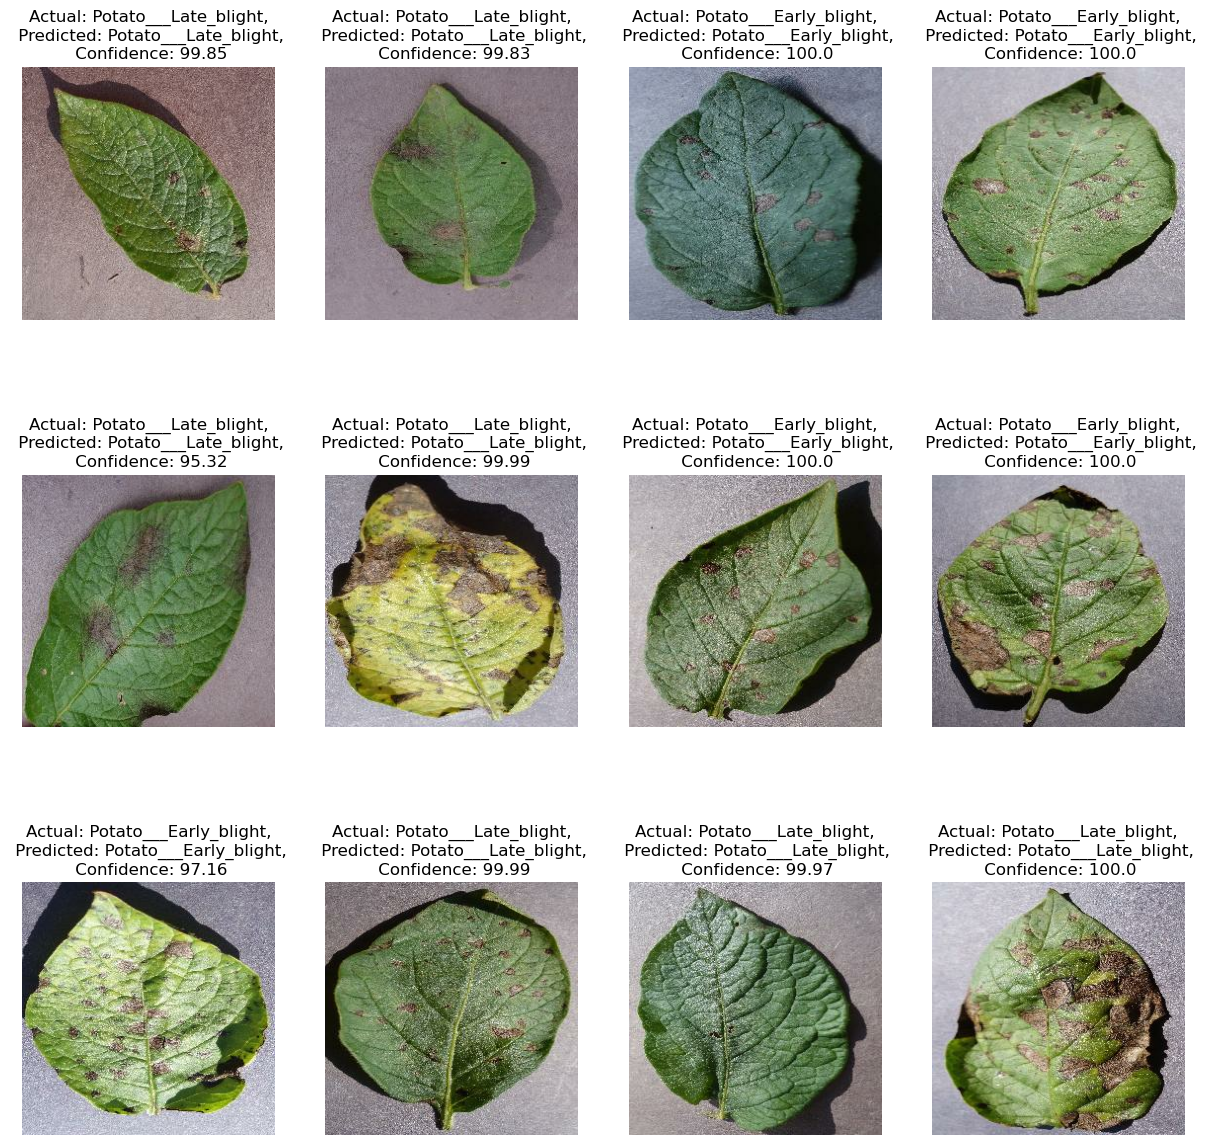

In [55]:
plt.figure(figsize=(15,15))
for images_batch, labels_batch in test_ds.take(1):
    for i in range(10):
        for i in range(12):
            ax=plt.subplot(3,4,i+1)
            plt.axis("off")
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]]
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")